# Investigation of Equivallent Formulations of Geometrical Optics
*Sanity checks for Ray Tracer for Cold Magnetised Plasma*

This iPython Notebook tests different formulations of the ray tracing equations. Among other things:
- Defines Apple-Hartree (AH) dispersion relations capable of handling both X- and O-modes and arbitrary (slowly varying) magnetic fields $B_0(r)$.
- Plots CMA-digram for different angles to a constant magnetic field.
- Compares tracing of simple O-mode in 1D (with 90° angle to $B_0$) using a) AH-dispersion and b) Reduced dispersion relation (i.e. $D = \omega^2 - \omega_p^2 - k c^2$).
- Compares results of tracing in characteristic ray parameter, $\tau$, with tracing in real time $t$.
- Verifies that reversing the sign of the EOMs (as is done in the Lopez-article) amounts to a time reversal $\tau \to - \tau$, which can be undone by also reversing the sign of the dispersion relation $\mathcal{D} \to -\mathcal{D}$.
- Verifies that we obtain the same results when tracing a ray using the AH-dispersion relations with a cutoff at $x=0$ as we obtain when tracing the simpler shifted and scaled dispersion relation $D = - x - k^2$ considered in the Lopez-article.

## Setup

In [2]:
import torch
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
import matplotlib as mpl
from scipy.integrate import solve_ivp, cumulative_trapezoid

In [3]:
# %matplotlib qt

In [4]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

### Torch Helper Library

To use automatic differentiation of the dispersion
function and its' dependencies, all calculations
must be done using torch tensors. I've build a wrapper
function called `torch_func` which may be used as a
decorator. Check out `./autograd_examples.ipynb` for examples on using the `torch_func` wrapper and doing automatic differentiation.

In [5]:
from torch_helper import to_torch, to_torch_3D, torch_func, inner_product, angle

In [6]:
# Example
@torch_func
def scale_vector(alpha: ('scalar'), a: ('vector', 'detach'), sign: ('any') = 'positive'):
    if sign == 'positive':
        return alpha*a
    else:
        return -alpha*a

scale_vector(2, np.array([[2, 2, 1], [2, 2, 1]]), sign='negative')

tensor([[-4., -4.],
        [-2., -4.],
        [-4., -2.]])

## Investigation of Ray Tracing with Different Dispersion Functions

### Apple Hartree Dispersion Relations

In [7]:
# Define Apple-Hartree dispersion relation
e = 1.0
eps_0 = 1.0
m_e = 1.0
c = 1.0
q = 1.0

@torch_func
def B_from_theta(theta: ('scalar', 'detach')):
    '''Returns function B_0(r) defining the B-field for position r'''

    @torch_func
    def B_0(r: ('vector', 'detach')):
        B0 = 0.4
        return B0 * torch.tensor([torch.cos(theta), 0, torch.sin(theta)]).reshape(3, -1).repeat(1, r.shape[-1])
    return B_0

# Currently set B_0 with theta = 90 deg.
B_0 = B_from_theta(torch.pi/2)

@torch_func
def get_theta(r: ('vector', 'detach'), k_dir: ('vector', 'detach')):
    return angle(B_0(r), k_dir)

@torch_func
def omega_c(r: ('vector', 'detach')):
    return q*torch.norm(B_0(r), dim=0)/m_e

@torch_func
def n_e(r: ('vector')):
    x, y, z = r
    return x

@torch_func
def omega_p_squared(r: ('vector')):
    return n_e(r) * e**2 / (eps_0 * m_e)

@torch_func
def X(r: ('vector'), omega: ('scalar')):
    return omega_p_squared(r)/(omega**2)

@torch_func
def Y(r: ('vector'), omega: ('scalar')):
    x, y, z = r
    return torch.ones(x.shape)*omega_c(r)/omega

@torch_func
def N(k: ('vector'), omega: ('scalar')):
    return c/omega * k

@torch_func
def denominator(X: ('scalar'), Y: ('scalar'), theta: ('scalar'), mode: ('any')):
    def Gamma(X, Y, theta, mode):
        sign = -1
        if mode == 'O':
            sign = 1
        return sign * torch.sqrt(Y**4 * (torch.sin(theta)**4)
            + 4*(Y**2)*((1-X)**2) * (torch.cos(theta)**2))
    
    return (2*(1-X)
        - Y**2*(torch.sin(theta)**2)
        + Gamma(X, Y, theta, mode))

@torch_func
def N_squared(r: ('vector'), omega: ('scalar'), theta: ('scalar'), mode: ('any')):
    _X = X(r, omega)
    _Y = Y(r, omega)
    return 1 - 2*_X*(1-_X)/denominator(_X, _Y, theta, mode)

@torch_func
def D(r: ('vector'), k: ('vector'), omega: ('scalar'), mode: ('any')):
    _theta = get_theta(r, k)
    _X = X(r, omega)
    _Y = Y(r, omega)
    _N = torch.norm(N(k, omega))
    return (denominator(_X, _Y, _theta, mode) * (1 - _N**2)
        - 2 * _X * (1-_X))

# NumPy Functions
def k_from_dir(k_dir, r, omega, mode):
    '''Returns k-vector in specified direction satisfying dispersion relation'''
    k_hat = k_dir/np.linalg.norm(k_dir)
    _theta = get_theta(r, k_dir).detach().numpy()
    N = np.emath.sqrt(N_squared(r, omega, theta=_theta, mode=mode).detach().numpy())
    return (N*omega/c)*k_hat

In [8]:
def trace_ray(r0, k0, omega0, tmin, tmax, D, D_args={}, rtol=1e-3, r_min=np.array([0, 0, 0]), r_max=np.array([1000,1000,1000])):
    q0 = np.hstack((r0,k0))
    
    def hit_boundary(t, q):
        tol = 1e-4
        return np.min([np.min(q[:3] - (r_min - tol)), np.min((r_max + tol) - q[:3])])
    hit_boundary.terminal = True
    hit_boundary.direction = -1

    # RHS of ray-tracer ODE
    def f(t, q):
        x, y, z, kx, ky, kz = q
        omega = torch.tensor(omega0, requires_grad=True)
        r = torch.tensor([x, y, z], requires_grad=True)
        k = torch.tensor([kx, ky, kz], requires_grad=True)

        Di = D(r, k, omega, **D_args)
        Di.backward()
        grad_r = r.grad
        grad_k = k.grad
        grad_omega = omega.grad
        RHS_r = - grad_k/grad_omega
        RHS_k = grad_r/grad_omega
        
        return torch.hstack((RHS_r, RHS_k)).detach().numpy()

    sol = solve_ivp(f, [tmin, tmax], q0, t_eval = np.linspace(tmin, tmax, 1000), events=hit_boundary, rtol=rtol, atol = (1e-3)*rtol)
    return sol


def trace_Apple_Hartree_ray(r0, k_dir, omega0, tmin, tmax, mode='O', rtol=1e-3, r_min=np.array([0, 0, 0]), r_max=np.array([1000,1000,1000])):
    k0 = k_from_dir(k_dir, r0, omega0, mode)
    return trace_ray(r0, k0, omega0, tmin, tmax, D, D_args={'mode': mode}, rtol=rtol, r_min=r_min, r_max=r_max)


### CMA-Diagrams for O- and X-modes at different angles

In [9]:
def X_UH(Y, theta):
    return (1 - Y**2)/(1-Y**2 * np.cos(theta)**2)

def Y_UH(X, theta):
    return np.sqrt((1-X)/(1-X*np.cos(theta)**2))

def plot_CMA(ax, theta, xlim=(0,2), ylim=(0,2), include_txt_annotations=True):
    X_arr = np.linspace(xlim[0], xlim[1], 1000)
    Y_arr = np.linspace(ylim[0], ylim[1], 1000)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'$\omega_p^2/\omega^2 \propto n_e$')
    ax.set_ylabel(r'$\omega_{ce}^2/\omega^2 \propto B$')
    ax.grid()

    # Plasma frequency (O-cutoff)
    ax.vlines(1, ylim[0], ylim[1], 'k', linestyles='dashed')

    # Cyclotron frequency (Resonance)
    ax.plot(X_arr, np.ones_like(X_arr), 'k')

    if theta > 0:
        # Upper hybrid resonance
        ax.plot(X_arr[X_arr < 1], Y_UH(X_arr[X_arr < 1], theta), '-k')

    # R-cutoff (X-cutoff)
    ax.plot(X_arr, 1 - X_arr, '--k')

    # L-cutoff (X-cutoff)
    ax.plot(X_arr, X_arr - 1, '--k')

    if include_txt_annotations:
        pct_x = np.diff(xlim)/100
        pct_y = np.diff(ylim)/100
        ax.text(1 + 1.5*pct_x, 70*pct_y, r'$\omega = \omega_p$', rotation=90)
        ax.text(1 + 16*pct_x, 1 + 3.5*pct_y, r'$\omega = \omega_{ce}$')
        if theta > 0:
            small_theta = (theta < 15*np.pi/180)
            ax.text(22*pct_x + small_theta*0.1, 27.5*pct_y + small_theta*0.1, r'$\omega = \omega_\mathrm{UH}$', rotation=-35)
        ax.text(2.5*pct_x, 25*pct_y, r'$\omega = \omega_R$', rotation=-45)
        ax.text(1 + 25*pct_x, 20*pct_y, r'$\omega = \omega_L$', rotation=45)

def plot_vlines_cutoffs_and_resonances(ax, Y, theta, ylim=(-1.5,1.5)):
    ax.vlines(1, ylim[0], ylim[1], 'k', linestyle='dashed')
    ax.vlines(X_UH(Y, theta), ylim[0], ylim[1], 'k', linestyle='solid')
    ax.vlines(1-Y, ylim[0], ylim[1], 'k', linestyle='dashed')
    ax.vlines(1+Y, ylim[0], ylim[1], 'k', linestyle='dashed')

def plot_Nsquared_vs_X(ax, Y, theta, omega0, xlim=(0,2), ylim=(-1.5,1.5)):
    X_arr = np.linspace(xlim[0], xlim[1], 1000)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.set_xlabel(r'$\omega_p^2/\omega^2 \propto n_e$')
    ax.set_ylabel(r'$N^2$')
    r_arr = np.array([X_arr, np.zeros_like(X_arr), np.zeros_like(X_arr)])
    ax.plot(X_arr, N_squared(torch.tensor(r_arr), omega0, theta, mode='O'), '--', color='tab:red')
    ax.plot(X_arr, N_squared(torch.tensor(r_arr), omega0, theta, mode='X'), '--', color='tab:blue')
    plot_vlines_cutoffs_and_resonances(ax, Y, theta, ylim)
    ax.fill_between(X_arr, ylim[0], 0, color='gainsboro')
    ax.text(1 - Y - 0.13, -1.3, r'$\omega = \omega_R$', rotation=90)
    ax.text(X_UH(Y, theta) - 0.13, 0.5, r'$\omega = \omega_{\mathrm{UH}}$', rotation=90)
    ax.text(1 + 0.02, -1.3, r'$\omega = \omega_p$', rotation=90)
    ax.text(1+Y + 0.02, -1.3, r'$\omega = \omega_L$', rotation=90)
    ax.grid()

def plot_x_vs_t_axis(ax, Y, theta, xlim, ylim):
    ax.invert_yaxis()
    ax.set_xlim(xlim)
    ax.grid()
    ax.set_xlabel(r'$\omega_p^2/\omega^2 \propto n_e$')
    ax.set_ylabel(r'$t$')
    plot_vlines_cutoffs_and_resonances(ax, Y, theta=theta, ylim=ylim)

In [10]:
theta_degs = [90, 30, 10, 0]
thetas = [theta_deg*np.pi/180 for theta_deg in theta_degs]
omega0 = 1.0

x0s = [0.0, 0.0, 1 + Y(np.zeros(3), omega0).detach().numpy()[0] - 0.04]
r0s = [np.array([x0, 1.0, 1.0]) for x0 in x0s]
k_dirs = [np.array([1.0, 0.0, 0.0]), np.array([1.0, 0.0, 0.0]), np.array([-1.0, 0.0, 0.0])]
modes = ['X', 'O', 'X']
labels = ['X', 'O', '']
colors = ['tab:blue', 'tab:red', 'tab:blue']

sols_for_theta = []

for theta in thetas:
    sols = []
    B_0 = B_from_theta(theta)
    for i, r0 in enumerate(r0s):
        sol = trace_Apple_Hartree_ray(r0, k_dirs[i], omega0, tmin=0, tmax=5, mode=modes[i], rtol=1e-4)
        x, y, z, kx, ky, kz = sol.y
        r = np.array([x, y, z])
        k = np.array([kx, ky, kz])
        sols.append({
            'sol': sol,
            't': sol.t,
            'r': r,
            'k': k
        })
    sols_for_theta.append(sols)

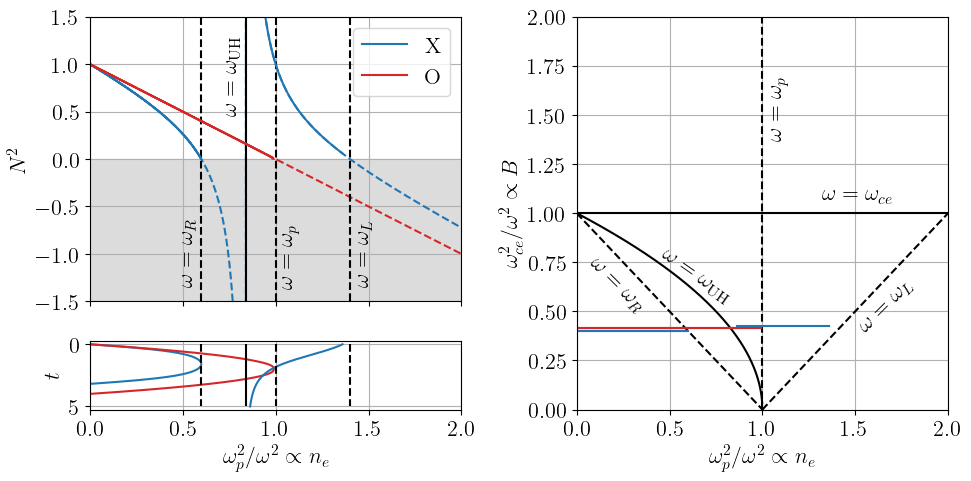

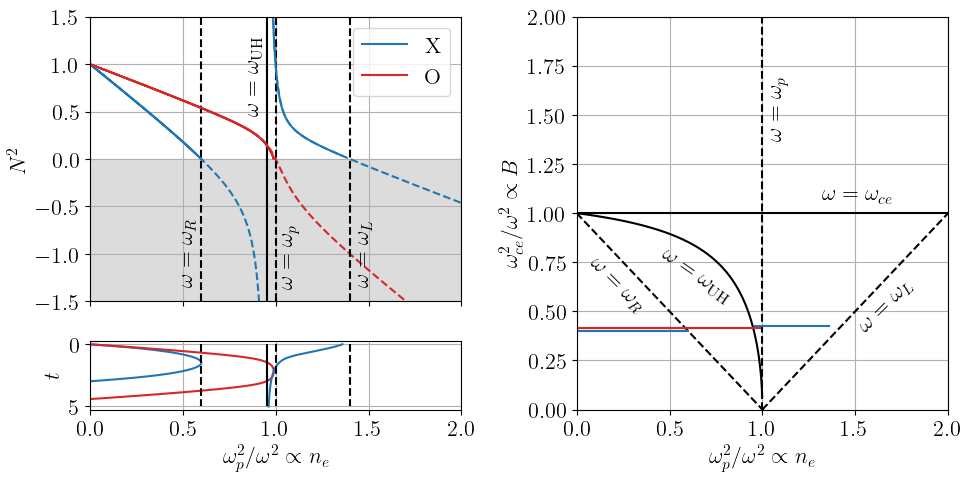

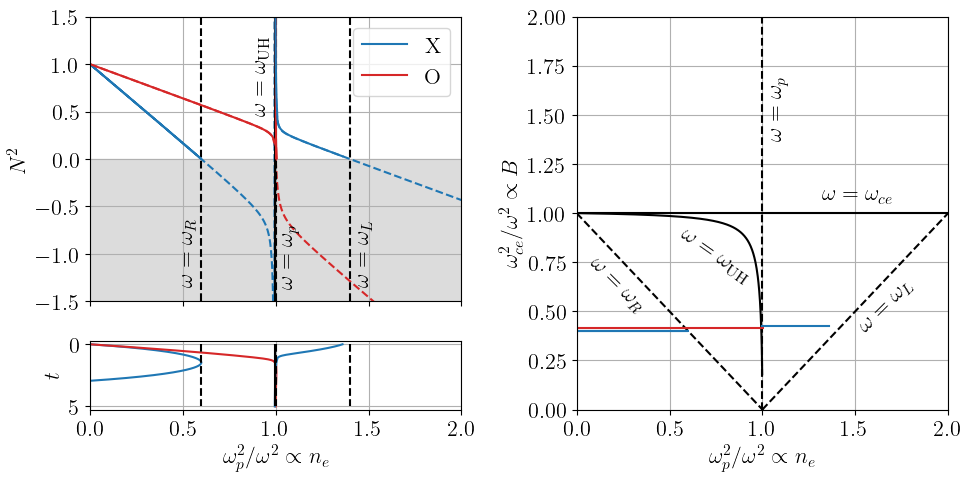

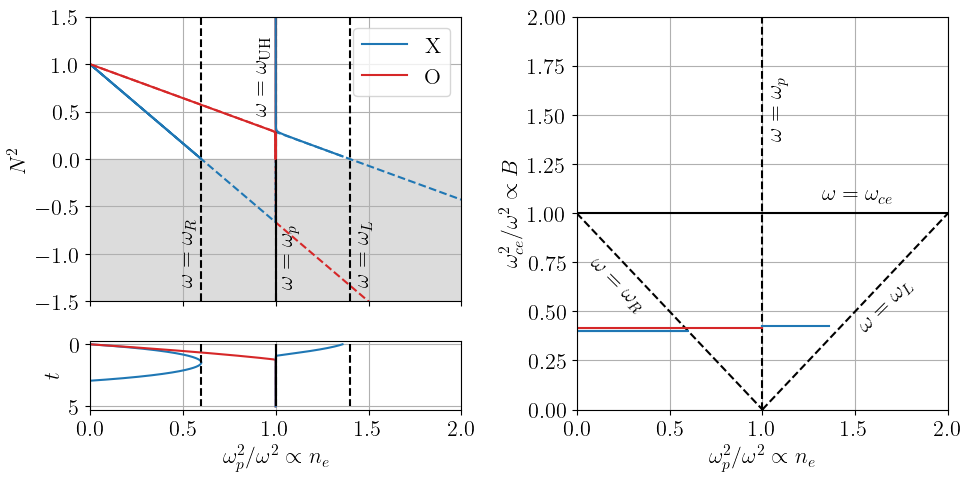

In [11]:
for j, _theta in enumerate(thetas):
   theta_deg = theta_degs[j]
   sols = sols_for_theta[j]

   fig = plt.figure(figsize=(10,5.1))
   gs = mpl.gridspec.GridSpec(4, 2, figure=fig)
   ax0 = fig.add_subplot(gs[:3,0])
   ax1 = fig.add_subplot(gs[:,1])
   ax2 = fig.add_subplot(gs[3:,0])
   ax0.sharex(ax2)
   plt.setp(ax0.get_xticklabels(), visible=False)

   xlim = (0, 2)
   plot_Nsquared_vs_X(ax0, Y(r0s[0], omega0), theta=_theta, omega0=omega0, xlim=xlim)
   plot_CMA(ax1, theta=_theta, xlim=xlim)

   for i, r0 in enumerate(r0s):
      sol, t, r, k = sols[i]['sol'], sols[i]['t'], sols[i]['r'], sols[i]['k']
      x, y, z = r
      _N = np.linalg.norm(N(k, omega0),axis=0)

      ax0.plot(x, _N**2, color=colors[i], label=labels[i])

      ylim = (0,2)
      ax1.plot(X(r, omega0), Y(r, omega0) + np.diff(ylim)/150*i, color=colors[i])
      
      ax2.plot(x, sol.t, color=colors[i])
   plot_x_vs_t_axis(ax2, Y(r0s[0], omega0), _theta, xlim=xlim, ylim=(sol.t.min(), sol.t.max()))

   ax0.legend()
   # plt.subplots_adjust(top=0.85)
   # fig.suptitle(r'Dispersion with $\theta = ' + str(theta_deg) + '^{\circ}$')
   fig.tight_layout()
   # fig.savefig('./plots/cold_trace__theta_' + str(theta_deg) + '.png', dpi=600)
   # fig.savefig('./plots/cold_trace__theta_' + str(theta_deg) + '.pdf')
   plt.show()

### Benchmarking against Simple Ray Tracer for O-Mode

In [12]:
@torch_func
def D_O(r: ('vector'), k: ('vector'), omega: ('scalar')):
    x, y, z = r
    return omega**2 - x - inner_product(k, k)

In [13]:
# Ray tracer function.

def trace_O_ray(r0, k0, omega0, tmin, tmax, rtol=1e-3, r_min=np.array([0, 0, 0]), r_max=np.array([1000,1000,1000])):
    return trace_ray(r0, k0, omega0, tmin, tmax, D=D_O, rtol=rtol, r_min=r_min, r_max=r_max)

In [14]:
sol = trace_O_ray(r0=np.array([0.0, 0.0, 0.0]), k0=np.array([1.0, 0.0, 0.0]), omega0=1.0, tmin=0, tmax=5)
x, y, z, kx, ky, kz = sol.y
r = [x, y, z]
k = [kx, ky, kz]
O_result = {'sol': sol, 't': sol.t, 'r': r, 'k': k}

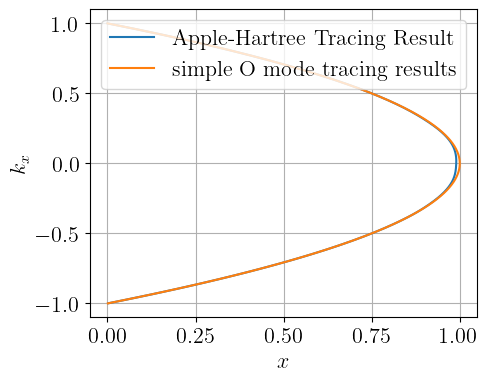

In [15]:
AH_O_result = sols_for_theta[theta_degs.index(90)][modes.index('O')]

plt.figure(figsize=(5,4))
plt.plot(AH_O_result['r'][0], AH_O_result['k'][0], label='Apple-Hartree Tracing Result')
plt.plot(r[0], k[0], label='simple O mode tracing results')
plt.xlabel(r'$x$')
plt.ylabel(r'$k_x$')
plt.legend()
plt.grid()
plt.show()

### Tracing in "parametric time" instead of "physical time"

We can trace the rays in $\tau$-parameter according to the hamiltonian equations:
$$
\partial_{\tau} r(\tau) = \partial_k \mathcal{D} \\
\partial_{\tau} k(\tau) = - \partial_r \mathcal{D} 
$$

According to Tracy, Eq. (3.26), p. 87 the parameter $\tau$ is related to the physical time by:
$$
\partial_{\tau} t = \partial_\omega \mathcal{D}
$$
In the simple O-mode case, we have $\partial_\omega \mathcal{D} = 2 \omega$, so with $\omega = 2$ the ray is simply traversed twise as fast.

In general, we should be able to get the physical time from
$$
t = t_0 + \int_{0}^{\tau} \partial_\omega \mathcal{D} \, d \tau
$$

In the following I check whether tracing in $\tau$-time and hereafter integrating to get the real time gives the same results as before:

In [16]:
def trace_ray_tau(r0, k0, omega0, tmin, tmax, D, D_args={}, rtol=1e-3, r_min=np.array([0, 0, 0]), r_max=np.array([1000,1000,1000])):
    q0 = np.hstack((r0,k0))

    def hit_boundary(t, q):
        tol = 1e-4
        return np.min([np.min(q[:3] - (r_min - tol)), np.min((r_max + tol) - q[:3])])
    hit_boundary.terminal = True
    hit_boundary.direction = -1

    # RHS of ray-tracer ODE
    def f(t, q):
        x, y, z, kx, ky, kz = q
        omega = torch.tensor(omega0, requires_grad=True)
        r = torch.tensor([x, y, z], requires_grad=True)
        k = torch.tensor([kx, ky, kz], requires_grad=True)

        Di = D(r, k, omega, **D_args)
        Di.backward()
        grad_r = r.grad
        grad_k = k.grad
        RHS_r = - grad_k
        RHS_k = grad_r
        
        return torch.hstack((RHS_r, RHS_k)).detach().numpy()

    sol = solve_ivp(f, [tmin, tmax], q0, t_eval = np.linspace(tmin, tmax, 1000), events=hit_boundary, rtol=rtol, atol = (1e-3)*rtol)
    return sol

def trace_O_ray_tau(r0, k0, omega0, tmin, tmax, rtol=1e-3, r_min=np.array([0, 0, 0]), r_max=np.array([1000,1000,1000])):
    return trace_ray_tau(r0, k0, omega0, tmin, tmax, D=D_O, rtol=rtol, r_min=r_min, r_max=r_max)

def trace_Apple_Hartree_ray_tau(r0, k_dir, omega0, tmin, tmax, mode='O', rtol=1e-3, r_min=np.array([0, 0, 0]), r_max=np.array([1000,1000,1000])):
    k0 = k_from_dir(k_dir, r0, omega0, mode)
    return trace_ray_tau(r0, k0, omega0, tmin, tmax, D, D_args={'mode': mode}, rtol=rtol, r_min=r_min, r_max=r_max)

def get_t(sol, omega, D, D_args = {}):
    # Get derivative of dispersion rel. w.r.t. omega
    grad_omega = np.zeros_like(sol.t)

    omega = torch.tensor(omega, requires_grad=True)
    for i, _t in enumerate(sol.t):
        Di = D(r=sol.y[:3,i], k=sol.y[3:,i], omega=omega, **D_args)
        grad_omega[i] = grad(Di, omega, create_graph=True)[0].detach().numpy()

    # Calculate physical time as t = ∫ d tau D_omega(tau)
    t = cumulative_trapezoid(grad_omega, sol.t, initial=0)
    return t

In [17]:
sol = trace_O_ray_tau(r0=np.array([0.0, 0.0, 0.0]), k0=np.array([1.0, 0.0, 0.0]), omega0=1.0, tmin=0, tmax=2.5)
x, y, z, kx, ky, kz = sol.y
r = [x, y, z]
k = [kx, ky, kz]
t = get_t(sol, omega=1.0, D=D_O)
O_result_tau = {'sol': sol, 't': t, 'r': r, 'k': k}

In [18]:
B_0 = B_from_theta(np.pi/2)
sol = trace_Apple_Hartree_ray_tau(r0=np.array([0.0, 0.0, 0.0]), k_dir=np.array([1.0, 0.0, 0.0]), omega0=1.0, tmin=0, tmax=12, mode='O')
x, y, z, kx, ky, kz = sol.y
r = [x, y, z]
k = [kx, ky, kz]
t = get_t(sol, omega=1.0, D=D, D_args = {'mode': 'O'})
AH_O_result_tau = {'sol': sol, 't': t, 'r': r, 'k': k}

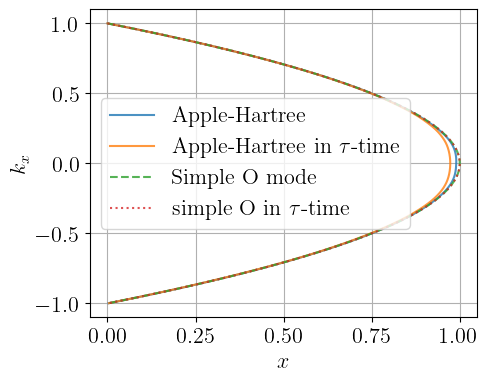

In [19]:
plt.figure(figsize=(5,4))
plt.plot(AH_O_result['r'][0], AH_O_result['k'][0], '-', label='Apple-Hartree', alpha=0.8)
plt.plot(AH_O_result_tau['r'][0], AH_O_result_tau['k'][0], '-', label=r'Apple-Hartree in $\tau$-time', alpha=0.8)
plt.plot(O_result['r'][0], O_result['k'][0], '--', label='Simple O mode', alpha=0.8)
plt.plot(O_result_tau['r'][0], O_result_tau['k'][0], ':', label=r'simple O in $\tau$-time', alpha=0.8)
plt.xlabel(r'$x$')
plt.ylabel(r'$k_x$')
plt.legend()
plt.grid()
plt.show()

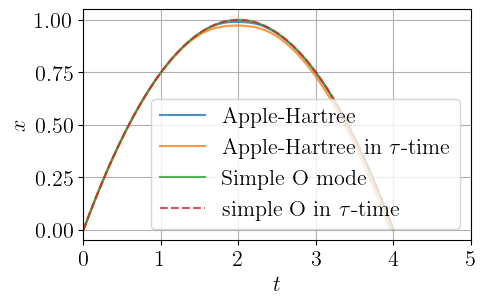

In [20]:
plt.figure(figsize=(5,3))
plt.plot(AH_O_result['t'], AH_O_result['r'][0], '-', label='Apple-Hartree', alpha=0.8)
plt.plot(AH_O_result_tau['t'], AH_O_result_tau['r'][0], '-', label=r'Apple-Hartree in $\tau$-time', alpha=0.8)
plt.plot(O_result['t'], O_result['r'][0], '-', label='Simple O mode', alpha=0.8)
plt.plot(O_result_tau['t'], O_result_tau['r'][0], '--', label=r'simple O in $\tau$-time', alpha=0.8)
plt.legend()
plt.xlim(0,5)
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.grid()
plt.show()

### Time Symmetry in Hamilton's Equations

Note: In Lopez (2020), the Hamilton Eqs. have inverse sign compared to Tracy and Mazzucato.
$$
\textbf{Lopez} \\
\partial_\tau x = \partial_k D \\
\partial_\tau k = - \partial_x D
$$
$$
\textbf{Tracy/Mazzucato} \\
\partial_\tau x = - \partial_k D \\
\partial_\tau k = \partial_x D
$$

My guess is that both signs are valid, since both $\mathcal{D}$ and $-\mathcal{D}$ are valid dispersion functions. Reversing sign of EOMs should be equivallent to a time reversal $\tau \to - \tau$. So this is merely a reflection of time symmetry of the equations of motions.

And when I simulate with reversed sign, it does indeed go back in time.

In [21]:
def trace_ray_tau_reversed(r0, k0, omega0, tmin, tmax, D, D_args={}, rtol=1e-3, r_min=np.array([0, 0, 0]), r_max=np.array([1000,1000,1000])):
    q0 = np.hstack((r0,k0))

    def hit_boundary(t, q):
        tol = 1e-4
        return np.min([np.min(q[:3] - (r_min - tol)), np.min((r_max + tol) - q[:3])])
    hit_boundary.terminal = True
    hit_boundary.direction = -1

    # RHS of ray-tracer ODE
    def f(t, q):
        x, y, z, kx, ky, kz = q
        omega = torch.tensor(omega0, requires_grad=True)
        r = torch.tensor([x, y, z], requires_grad=True)
        k = torch.tensor([kx, ky, kz], requires_grad=True)

        Di = D(r, k, omega, **D_args)
        Di.backward()
        grad_r = r.grad
        grad_k = k.grad
        RHS_r = grad_k
        RHS_k = - grad_r
        
        return torch.hstack((RHS_r, RHS_k)).detach().numpy()

    sol = solve_ivp(f, [tmin, tmax], q0, t_eval = np.linspace(tmin, tmax, 1000), events=hit_boundary, rtol=rtol, atol = (1e-3)*rtol)
    return sol

def trace_O_ray_tau_reversed(r0, k0, omega0, tmin, tmax, rtol=1e-3, r_min=np.array([0, 0, 0]), r_max=np.array([1000,1000,1000])):
    return trace_ray_tau_reversed(r0, k0, omega0, tmin, tmax, D=D_O, rtol=rtol, r_min=r_min, r_max=r_max)

**Note: In the simulation below, I have reversed the sign of $k$ demonstrating that changing sign results in us propagating backwards in time**

We could just as well have kept the sign of $k$ and then reversed the sign of $D$ to get the same result.

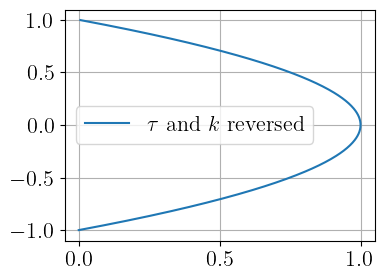

In [22]:
sol = trace_O_ray_tau_reversed(r0=np.array([0.0, 0.0, 0.0]), k0=np.array([-1.0, 0.0, 0.0]), omega0=1.0, tmin=0, tmax=5)
x, y, z, kx, ky, kz = sol.y
r = [x, y, z]
k = [kx, ky, kz]
plt.figure(figsize=(4,3))
plt.plot(r[0], k[0], label=r'$\tau$ and $k$ reversed')
plt.legend()
plt.grid()
plt.show()

### Shifting Density Profile

In [38]:
B_0 = B_from_theta(np.pi/2)

@torch_func
def X(r: ('vector'), omega: ('scalar')):
    x, y, z = r
    return (1 + x)/(omega**2)

In [39]:
sol = trace_Apple_Hartree_ray(r0=np.array([-1.0, 0.0, 0.0]),
                              k_dir=np.array([1.0, 0.0, 0.0]),
                              omega0=1.0,
                              tmin=0, tmax=5,
                              r_min=np.array([-1.0, 0, 0]),
                              mode='O',
                              rtol=1e-3)

x, y, z, kx, ky, kz = sol.y
r = np.array([x, y, z])
k = np.array([kx, ky, kz])
shifted_AH_O_result = {'sol': sol, 't': sol.t, 'r': r, 'k': k}

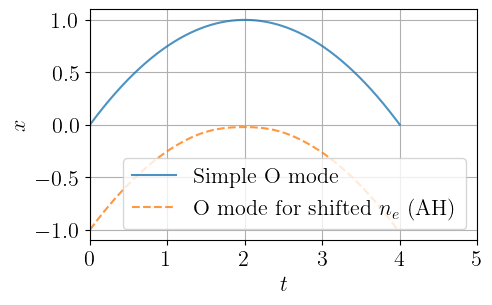

In [40]:
plt.figure(figsize=(5,3))
plt.plot(O_result['t'], O_result['r'][0], '-', label='Simple O mode', alpha=0.8)
plt.plot(shifted_AH_O_result['t'], shifted_AH_O_result['r'][0], '--', label=r'O mode for shifted $n_e$ (AH)', alpha=0.8)
plt.legend()
plt.xlim(0,5)
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.grid()
plt.show()

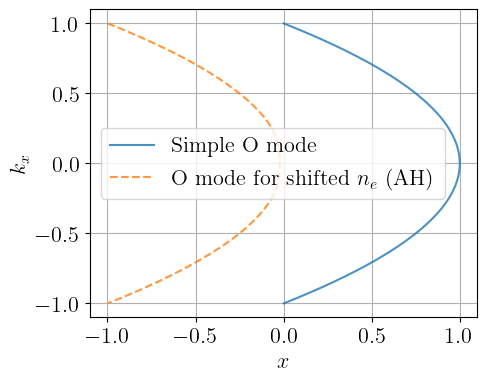

In [26]:
plt.figure(figsize=(5,4))
plt.plot(O_result['r'][0], O_result['k'][0], '-', label='Simple O mode', alpha=0.8)
plt.plot(shifted_AH_O_result['r'][0], shifted_AH_O_result['k'][0], '--', label=r'O mode for shifted $n_e$ (AH)', alpha=0.8)
plt.xlabel(r'$x$')
plt.ylabel(r'$k_x$')
plt.legend()
plt.grid()
plt.show()

### Shifting and Scaling Density Profile (As in Lopez 2020)

In [27]:
@torch_func
def D_O_Lopez(r: ('vector'), k: ('vector'), omega: ('scalar')):
    x, y, z = r
    return - x - inner_product(k, k)

def trace_O_ray_Lopez(r0, k0, omega0, tmin, tmax, rtol=1e-3, r_min=np.array([-1, 0, 0]), r_max=np.array([1000,1000,1000])):
    return trace_ray_tau(r0, k0, omega0, tmin, tmax, D=D_O_Lopez, rtol=rtol, r_min=r_min, r_max=r_max)

In [31]:
sol = trace_O_ray_Lopez(r0=np.array([-1.0, 0.0, 0.0]),
                              k0=np.array([1.0, 0.0, 0.0]),
                              omega0=1.0,
                              tmin=0, tmax=5,
                              r_min=np.array([-1, 0, 0]),
                              rtol=1e-3)

x, y, z, kx, ky, kz = sol.y
r = np.array([x, y, z])
k = np.array([kx, ky, kz])
Lopez_O_result = {'sol': sol, 't': sol.t, 'r': r, 'k': k}

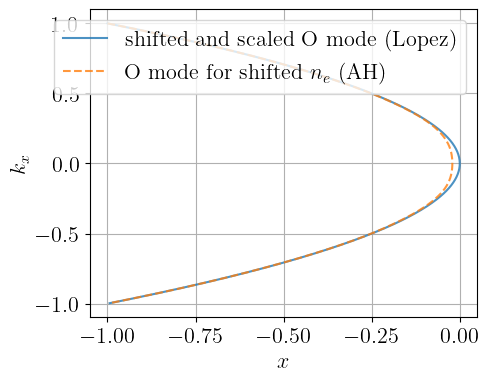

In [29]:
plt.figure(figsize=(5,4))
plt.plot(Lopez_O_result['r'][0], Lopez_O_result['k'][0], '-', label='shifted and scaled O mode (Lopez)', alpha=0.8)
plt.plot(shifted_AH_O_result['r'][0], shifted_AH_O_result['k'][0], '--', label=r'O mode for shifted $n_e$ (AH)', alpha=0.8)
plt.xlabel(r'$x$')
plt.ylabel(r'$k_x$')
plt.legend()
plt.grid()
plt.show()